Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]
2. Sudden flares of active galactic nuclei
3. Supernovae

**Tasks**

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1. Read in solutions/transient.npy. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as: 

    $y = b$, for $t < t_0$ 

    $y = b + A \exp{[-\alpha (t - t_0)]}$, for $t \geq t_0$ 

    where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

    Code this burst model, and code a likelihood function for this data with the burst model. 

    Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.

3. Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of ${b, \ A, \ t_0, \ \alpha}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b \in Uniform[0, 50]$, $A \in Uniform[0, 50]$, $t_0 \in Uniform[0, 100]$, and $ln(\alpha) \in Uniform[-5, 5]$ (careful: uniform in $ln(\alpha)$, not $\alpha$).

4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, $[68, 95] %$ credible levels and quantiles, and titles.

6. Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0 = X_{-Z}^{+Y}$


In [152]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization.hist
import astroML.stats as astroMLstats
import emcee
import corner

from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import uniform
from IPython.display import display, Latex

In [153]:
def model(t, b, A, alpha, t_0):
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
    
def log_prior(params, bounds):
    b, A, ln_alpha, t_0 = params
    if (bounds[0][0] < b < bounds[0][1] and
        bounds[1][0] < A < bounds[1][1] and
        bounds[2][0] < ln_alpha < bounds[2][1] and
        bounds[3][0] < t_0 < bounds[3][1]):
        return 0.0  # log(1)
    return -np.inf

def log_likelihood(params, t, data, err):
    b, A, ln_alpha, t_0 = params
    alpha = np.exp(ln_alpha)
    model_flux = model(t, b, A, alpha, t_0)
    return -0.5 * np.sum(((data - model_flux) / err)**2 + np.log(2 * np.pi * err**2))

def log_posterior(params, t, data, err, bounds):
    lp = log_prior(params, bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, data, err)

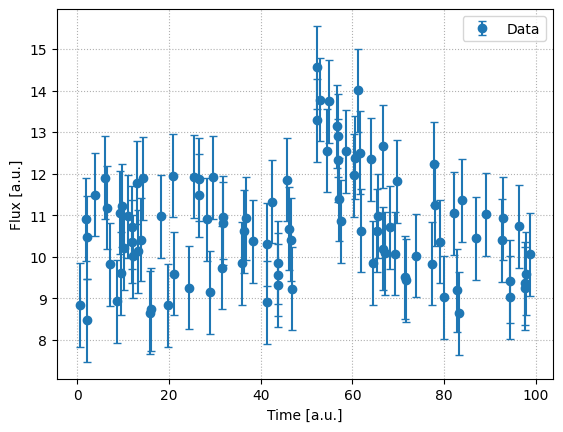

In [154]:
# Import data
path = '/home/alessia_pozzi/Astrostatistic/11_Bayesian/transient.npy'
data = np.load(path)

t = data[:, 0]
flux = data[:, 1]
err_flux = data[:, 2]

# Plot data
plt.errorbar(t, flux, err_flux, fmt='o', capsize=3, label = 'Data')
#plt.title()
plt.xlabel('Time [a.u.]')
plt.ylabel('Flux [a.u.]')
plt.legend()
plt.grid(linestyle=':')
plt.show()

In [163]:
# Limits of parameters distribution
# N.B.: The order of the parameter is: b, A, t_0, ln(alpha)
bounds = [[0, 50], [0, 50], [-5, 5], [0, 100]]

ndim = 4  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
burn = 10000  # 'burn-in' period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

np.random.seed(0)
starting_guesses = np.array([
    np.random.uniform(bounds[0][0], bounds[0][1], nwalkers),       # b
    np.random.uniform(bounds[1][0], bounds[1][1], nwalkers),       # A
    np.random.uniform(bounds[2][0], bounds[2][1], nwalkers),       # ln(alpha)
    np.random.uniform(bounds[3][0], bounds[3][1], nwalkers),       # t_0
]).T

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, flux, err_flux, bounds))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

tau = sampler.get_autocorr_time()
print(tau)
thin = int(np.max(tau)) + 1

samples = sampler.get_chain(discard=burn, thin=thin, flat=True)

print(f'Original chain: {sampler.chain.shape}') #original chain structure
print(f'Burn-in: {burn}, Thin: {thin}')
print(f'Shape after thinning: {samples.shape}')

/tmp/ipykernel_16716/307378680.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
  0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_16716/307378680.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
100%|██████████| 100000/100000 [01:59<00:00, 838.79it/s]


[ 52.3223632  163.73542626 202.08534591 139.91012466]
Original chain: (50, 100000, 4)
Burn-in: 10000, Thin: 203
Shape after thinning: (22150, 4)


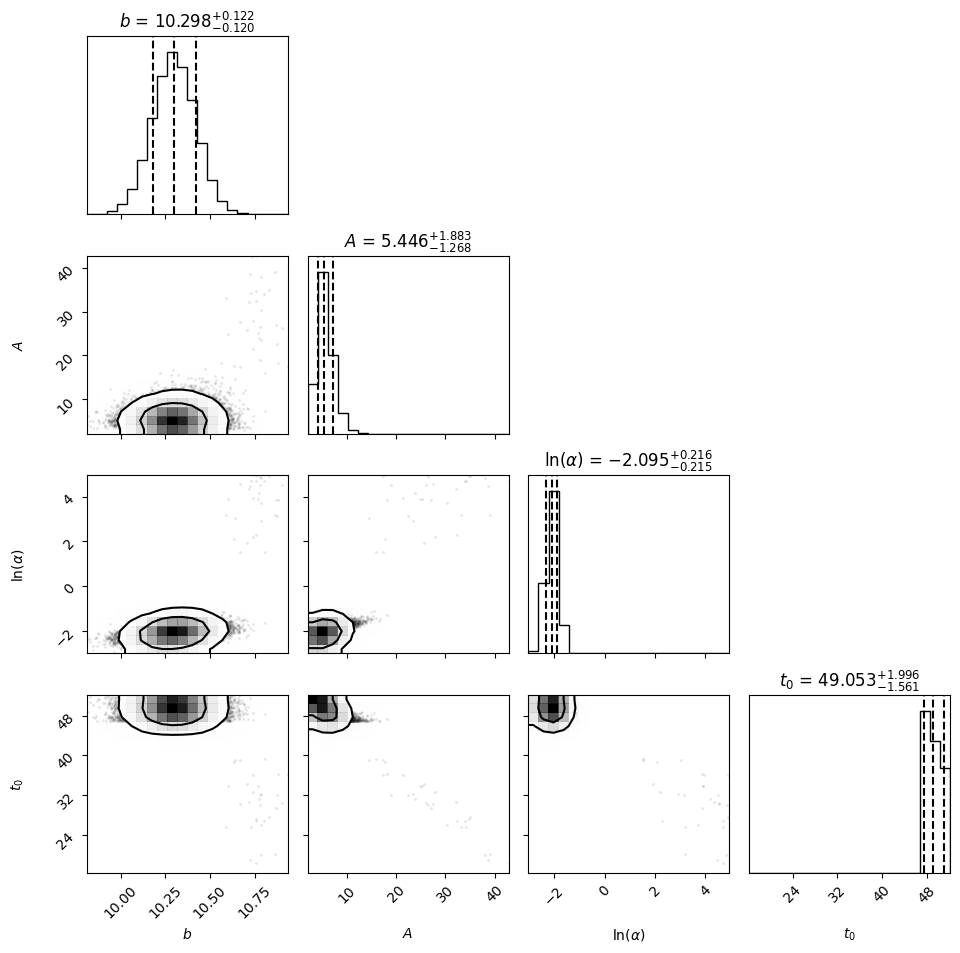

In [164]:
labels = [r'$b$', r'$A$', r'$\ln(\alpha)$', r'$t_0$']
fig = corner.corner(samples, labels=labels, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_fmt='.3f', 
                    title_kwargs={'fontsize': 12}, 
                    levels=(0.68, 0.95), 
                    smooth=1.0)

fig.tight_layout()

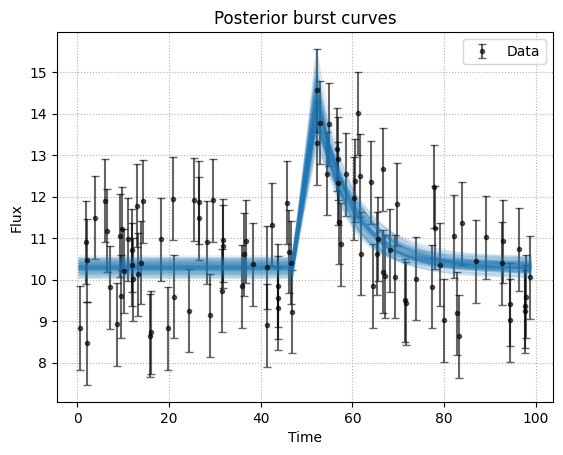

In [165]:
# Estrai 100 campioni casuali
posterior_samples = samples[np.random.choice(samples.shape[0], 100, replace=False)]

# Costruisci i modelli
def model(t, b, A, ln_alpha, t_0):
    alpha = np.exp(ln_alpha)
    exp_term = np.exp(-np.clip(alpha * (t - t_0), -700, 700))  # evita overflow
    return np.where(t < t_0, b, b + A * exp_term)

# Plotta i dati originali
plt.errorbar(t, flux, yerr=err_flux, fmt='.', color = 'k', capsize=3, label='Data', alpha=0.6)

# Plotta le curve della posterior
for b, A, ln_alpha, t_0 in posterior_samples:
    plt.plot(t, model(t, b, A, ln_alpha, t_0), color='C0', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior burst curves')
plt.legend()
plt.grid(linestyle=':')
plt.show()

In [167]:
percentiles_90 = [16, 84]
params = ['b', 'A', r'ln(\alpha)', 't_0']

latex_output = r'\begin{array}{l}'

for i, param in enumerate(params):
    param_samples = samples[:, i]
    median = np.median(param_samples)
    lower, upper = np.percentile(param_samples, percentiles_90)

    latex_output += f'{param} &= {median:.3f}_{{-{median-lower:.3f}}}^{{+{upper-median:.3f}}} && \\\\'

latex_output += r'\end{array}'

display(Latex(latex_output))

<IPython.core.display.Latex object>